Illustration of Voronoi method to separate Facial Landmarks to different AOIs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
import matplotlib.image as mpimg
import matplotlib.colors as mcolors
from matplotlib.patches import Polygon

In [2]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite
    polygons by extending infinite ridges to a specified radius.

    Parameters
    ----------
    vor : Voronoi
        Input Voronoi diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of list of ints
        Indices of vertices in each revised Voronoi region.
    vertices : ndarray
        Coordinates for revised Voronoi vertices.
    """
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map from ridge vertices to ridge points
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region_index in enumerate(vor.point_region):
        vertices = vor.regions[region_index]

        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Region with some infinite edges
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0 or v1 < 0:
                # Infinite ridge
                v_finite = v1 if v1 >= 0 else v2
                v_finite_point = vor.vertices[v_finite]
                p1_point = vor.points[p1]
                p2_point = vor.points[p2]

                # Tangent
                tangent = p2_point - p1_point
                tangent /= np.linalg.norm(tangent)
                # Normal vector
                normal = np.array([-tangent[1], tangent[0]])

                # Direction from center to midpoint of edge (to decide sign)
                midpoint = (p1_point + p2_point) / 2
                direction = np.sign(np.dot(midpoint - center, normal)) * normal

                far_point = v_finite_point + direction * radius
                new_vertices.append(far_point.tolist())
                new_region.append(len(new_vertices) - 1)

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = [v for _, v in sorted(zip(angles, new_region))]

        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

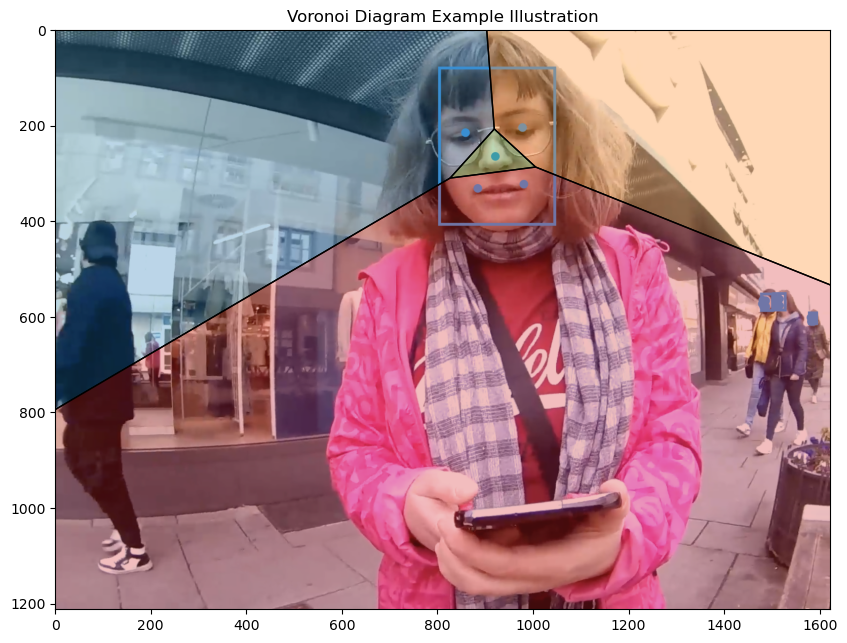

In [4]:
# get image
img = mpimg.imread('/Users/alina/Downloads/Thesis/raw/12_1 1094.png')
height, width = img.shape[:2]

# AOI coordinates on the image
points = np.array([
    [860, 212],
    [978, 203],
    [920, 266],
    [928, 328],
])

vor = Voronoi(points)

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(img, origin='upper')

ax.set_xlim(0, width)
ax.set_ylim(height, 0)  # flip Y axis for image coords

colors = list(mcolors.TABLEAU_COLORS.values())
colors = [mcolors.to_rgba(c, alpha=0.3) for c in colors]  # semi-transparent

regions, vertices = voronoi_finite_polygons_2d(vor, radius=5000)

# Plot filled regions
for idx, region in enumerate(regions):
    polygon = vertices[region]
    poly_patch = Polygon(polygon, facecolor=colors[idx % len(colors)],
                         edgecolor='black', linewidth=1)
    ax.add_patch(poly_patch)

# Plot AOI points on top
#ax.plot(points[:, 0], points[:, 1], 'bo', markersize=8)

ax.set_aspect('equal')
plt.title("Voronoi Diagram Example Illustration")
plt.show()